In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(98765)

In [2]:
# conformal prediction with least squares
def CP_LS(X,Y,x,alpha,weights=[],tags=[]):
    # weights are used for computing quantiles for the prediction interval
    # tags are used as weights in weighted least squares regression
    n = len(Y)
    
    if(len(tags)==0):
        tags = np.ones(n+1)
    
    if(len(weights)==0):
        weights = np.ones(n+1)
    if(len(weights)==n):
        weights = np.r_[weights,1]
    weights = weights / np.sum(weights)
    
    # randomly permute one weight for the regression
    random_ind = int(np.where(np.random.multinomial(1,weights,1))[1])
    tags[np.c_[random_ind,n]] = tags[np.c_[n,random_ind]]

    XtX = (X.T*tags[:-1]).dot(X) + np.outer(x,x)*tags[-1]
    a = Y - X.dot(np.linalg.solve(XtX,(X.T*tags[:-1]).dot(Y)))
    b = -X.dot(np.linalg.solve(XtX,x))*tags[-1]
    a1 = -x.T.dot(np.linalg.solve(XtX,(X.T*tags[:-1]).dot(Y)))
    b1 = 1 - x.T.dot(np.linalg.solve(XtX,x))*tags[-1]
    # if we run weighted least squares on (X[1,],Y[1]),...(X[n,],Y[n]),(x,y)
    # then a + b*y = residuals of data points 1,..,n
    # and a1 + b1*y = residual of data point n+1
    
    y_knots = np.sort(np.unique(np.r_[((a-a1)/(b1-b))[b1-b!=0],((-a-a1)/(b1+b))[b1+b!=0]]))
    y_inds_keep = np.where( ((np.abs(np.outer(a1+b1*y_knots,np.ones(n))) > \
       np.abs(np.outer(np.ones(len(y_knots)),a)+np.outer(y_knots,b))) *\
                             weights[:-1] ).sum(1) <= 1-alpha )[0] 
    y_PI = np.array([y_knots[y_inds_keep.min()],y_knots[y_inds_keep.max()]])
    if(weights[:-1].sum() <= 1-alpha):
        y_PI = np.array([-np.inf,np.inf])
    return y_PI


In [3]:
# generate data

# parameters for all settings
np.random.seed(12345)
alpha = 0.1
N = 2000
p = 4
train_lag = 100 # start predicting after train_lag many observations
ntrial = 200
rho = 0.99; rho_LS = 0.99

X = np.random.normal(size=(ntrial,N,p))
Y = np.zeros((3,ntrial,N))
noise = np.random.normal(size=(ntrial,N))

# setting 1: i.i.d. data
beta_1 = np.array([2,1,0,0])
Y[0] = X.dot(beta_1) + noise

# setting 2: changepoints
changepoints = np.r_[500,1500]
n_changepoint = 2
beta_2 = np.array([[2,1,0,0],[0,-2,-1,0],[0,0,2,1]])
for i in np.arange(1+n_changepoint):
    if(i==0):
        ind_min = 0
    else:
        ind_min = changepoints[i-1]
    if(i==n_changepoint):
        ind_max = N
    else:
        ind_max = changepoints[i]
    Y[1,:,ind_min:ind_max] = X[:,ind_min:ind_max].dot(beta_2[i])\
        + noise[:,ind_min:ind_max]

# setting 3: distribution drift
beta_start = np.array([2,1,0,0])
beta_end = np.array([0,0,2,1])
beta_3 = beta_start + np.outer(np.arange(N)/(N-1),beta_end-beta_start)
for i in np.arange(N):
    Y[2,:,i] = X[:,i].dot(beta_3[i])+noise[:,i]

setting_names = ['Setting 1 (i.i.d. data)',\
                     'Setting 2 (changepoints)','Setting 3 (distribution drift)']

In [4]:
# run all methods
PI_CP_LS = np.zeros((3,ntrial,N,2))
PI_CP_LS[:,:,:train_lag,0]=-np.inf;PI_CP_LS[:,:,:train_lag,1]=np.inf
PI_nexCP_LS = np.copy(PI_CP_LS)
PI_nexCP_WLS = np.copy(PI_CP_LS)
        
for itrial in np.arange(ntrial):
    for n in np.arange(train_lag,N):
        weights=rho**(np.arange(n,0,-1))
        tags=rho_LS**(np.arange(n,-1,-1))
        for setting in np.arange(3):
            # CP+LS
            PI_CP_LS[setting,itrial,n,:] = \
                CP_LS(X[itrial,:n,:],Y[setting,itrial,:n],X[itrial,n,:],alpha)
            # nexCP+LS
            PI_nexCP_LS[setting,itrial,n,:] = \
                CP_LS(X[itrial,:n,:],Y[setting,itrial,:n],X[itrial,n,:],alpha,\
                    weights=weights)
            # nexCP+WLS
            PI_nexCP_WLS[setting,itrial,n,:] = \
                CP_LS(X[itrial,:n,:],Y[setting,itrial,:n],X[itrial,n,:],alpha,\
                    weights=weights,tags=tags)


In [5]:
# compute coverage and PI width for all settings
cov_CP_LS = (PI_CP_LS[:,:,train_lag:,0]<=Y[:,:,train_lag:])*\
    (PI_CP_LS[:,:,train_lag:,1]>=Y[:,:,train_lag:])
PI_width_CP_LS = PI_CP_LS[:,:,train_lag:,1]-PI_CP_LS[:,:,train_lag:,0]
cov_nexCP_LS = (PI_nexCP_LS[:,:,train_lag:,0]<=Y[:,:,train_lag:])*\
    (PI_nexCP_LS[:,:,train_lag:,1]>=Y[:,:,train_lag:])
PI_width_nexCP_LS = PI_nexCP_LS[:,:,train_lag:,1]-PI_nexCP_LS[:,:,train_lag:,0]
cov_nexCP_WLS = (PI_nexCP_WLS[:,:,train_lag:,0]<=Y[:,:,train_lag:])*\
    (PI_nexCP_WLS[:,:,train_lag:,1]>=Y[:,:,train_lag:])
PI_width_nexCP_WLS = PI_nexCP_WLS[:,:,train_lag:,1]-PI_nexCP_WLS[:,:,train_lag:,0]

# save results
for setting in np.arange(3):
    setting_ = setting+1
    np.savetxt(('results/simulation_setting%d_cov_CP_LS.txt' %setting_),\
               cov_CP_LS[setting].T)
    np.savetxt(('results/simulation_setting%d_PI_width_CP_LS.txt' %setting_),\
               PI_width_CP_LS[setting].T)
    np.savetxt(('results/simulation_setting%d_cov_nexCP_LS.txt' %setting_),\
               cov_nexCP_LS[setting].T)
    np.savetxt(('results/simulation_setting%d_PI_width_nexCP_LS.txt' %setting_),\
               PI_width_nexCP_LS[setting].T)
    np.savetxt(('results/simulation_setting%d_cov_nexCP_WLS.txt' %setting_),\
               cov_nexCP_WLS[setting].T)
    np.savetxt(('results/simulation_setting%d_PI_width_nexCP_WLS.txt' %setting_),\
               PI_width_nexCP_WLS[setting].T)


In [6]:
for setting in np.arange(3):
    print(np.array([[setting_names[setting],'',''],\
        ['CP+LS    ',np.mean(cov_CP_LS[setting]),np.mean(PI_width_CP_LS[setting])],\
        ['nexCP+LS ',np.mean(cov_nexCP_LS[setting]),np.mean(PI_width_nexCP_LS[setting])],\
        ['nexCP+WLS',np.mean(cov_nexCP_WLS[setting]),np.mean(PI_width_nexCP_WLS[setting])]]))


[['Setting 1 (i.i.d. data)' '' '']
 ['CP+LS    ' '0.9004131578947369' '3.310561336915297']
 ['nexCP+LS ' '0.9069605263157895' '3.38842902316347']
 ['nexCP+WLS' '0.9071052631578947' '3.4152444920551224']]
[['Setting 2 (changepoints)' '' '']
 ['CP+LS    ' '0.8348921052631579' '5.989573523044591']
 ['nexCP+LS ' '0.8836473684210526' '6.825416334979604']
 ['nexCP+WLS' '0.9062947368421053' '4.125188086429458']]
[['Setting 3 (distribution drift)' '' '']
 ['CP+LS    ' '0.8384315789473684' '3.7319038510437257']
 ['nexCP+LS ' '0.8883131578947369' '4.286732223318121']
 ['nexCP+WLS' '0.9067368421052632' '3.4502095649023796']]


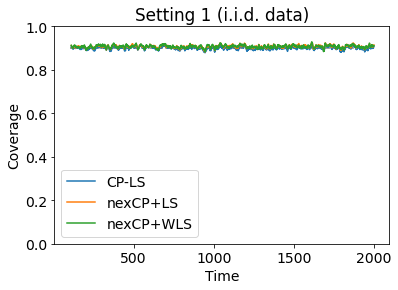

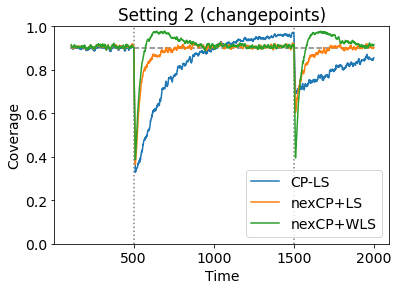

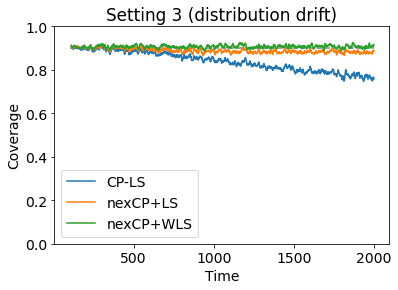

In [7]:
plt.rcParams.update({'font.size': 14})

window = 10 # will display a rolling average

def rolling_avg(x,window):
    return np.convolve(x,np.ones(window)/window)[(window-1):-window]
    
for setting in np.arange(3):
    plt.plot(np.arange(train_lag+window,N),\
             rolling_avg(np.mean(cov_CP_LS[setting],0),window))
    plt.plot(np.arange(train_lag+window,N),\
             rolling_avg(np.mean(cov_nexCP_LS[setting],0),window))
    plt.plot(np.arange(train_lag+window,N),\
             rolling_avg(np.mean(cov_nexCP_WLS[setting],0),window))
    plt.hlines(1-alpha,xmin=train_lag,xmax=N,linestyles='--',colors='gray')
    if(setting == 1):
        for i in np.arange(n_changepoint):
            plt.vlines(changepoints[i],ymin=0,ymax=1,linestyles=':',colors='gray')
    plt.legend(['CP-LS','nexCP+LS','nexCP+WLS'])
    plt.title(setting_names[setting])
    plt.ylabel('Coverage')
    plt.xlabel('Time')
    plt.ylim([0,1])
    setting_ = setting+1
    plt.savefig(('results/simulation_coverage_setting%d.png' %setting_),\
                dpi=400,bbox_inches='tight')
    plt.show()

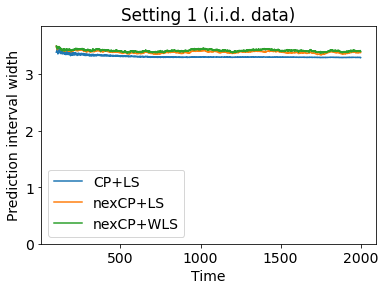

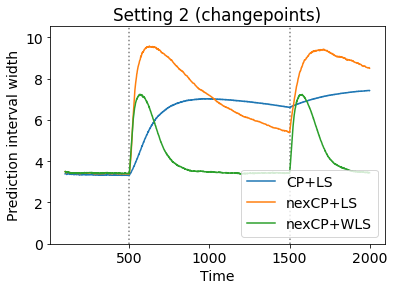

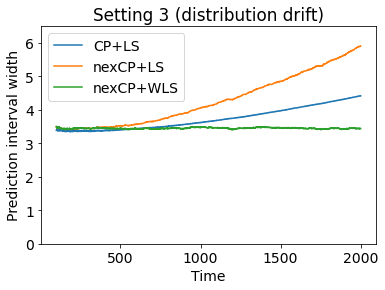

In [8]:
plt.rcParams.update({'font.size': 14})
for setting in np.arange(3):
    plt.plot(np.arange(train_lag,N),np.mean(PI_width_CP_LS[setting],0))
    plt.plot(np.arange(train_lag,N),np.mean(PI_width_nexCP_LS[setting],0))
    plt.plot(np.arange(train_lag,N),np.mean(PI_width_nexCP_WLS[setting],0))
    ymax = np.max(np.r_[np.mean(PI_width_CP_LS[setting],0).max(),\
        np.mean(PI_width_nexCP_LS[setting],0).max(),\
            np.mean(PI_width_nexCP_WLS[setting],0).max()])*1.1
    if(setting == 1):
        for i in np.arange(n_changepoint):
            plt.vlines(changepoints[i],ymin=0,ymax=ymax,linestyles=':',colors='gray')
    plt.legend(['CP+LS','nexCP+LS','nexCP+WLS'])
    plt.title(setting_names[setting])
    plt.ylabel('Prediction interval width')
    plt.xlabel('Time')
    plt.ylim([0,ymax])
    setting_ = setting+1
    plt.savefig(('results/simulation_PI_width_setting%d.png' %setting_),\
                dpi=400,bbox_inches='tight')
    plt.show()
